# Implementing Quantum Fourier Transform
ECS7011P - Quantum Programming - 2023/24

Author: Chin-Yun Yu

To run this notebook, the following packages are required:

- `qiskit`
- `qiskit-aer`
- `numpy`
- `matplotlib`

In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_distribution, plot_bloch_multivector
from typing import List, Tuple, Iterable
from functools import reduce, partial
import matplotlib.pyplot as plt
import math

simulator = AerSimulator()

## Abstract

## Introduction


### The Classical Discrete Fourier Transform

In the classical discrete Fourier transform (DFT), given a vector of complex numbers $x[t], 0 \leq t < N$ and $N = 2^n$, the Fourier transform is defined as

$
\begin{align}
X[k] = \sum_{t=0}^{N-1} x[t] e^{-2\pi i \frac{kt}{N}} ,
\end{align}
$

where $X[k]$ is the Fourier transform of $x[t]$. In digital signal processing, $t$ is often interpreted as time, and $k$ is the frequency. $X[k]$ is the projection of the signal $x[t]$ onto the frequency $k$ (more precisely, the angular frequency $2\pi k/N$).

We can represent the DFT as a matrix-vector multiplication:

$
\begin{align}
\begin{vmatrix}
X[0] \\ X[1] \\ \vdots \\ X[N-1]
\end{vmatrix} &= \begin{vmatrix}
1 & 1 & 1 & \cdots & 1 \\
1 & \omega & \omega^2 & \cdots & \omega^{N-1} \\
1 & \omega^2 & \omega^4 & \cdots & \omega^{2(N-1)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \omega^{N-1} & \omega^{2(N-1)} & \cdots & \omega^{(N-1)(N-1)}
\end{vmatrix} \begin{vmatrix}
x[0] \\ x[1] \\ \vdots \\ x[N-1]
\end{vmatrix},
\end{align}
$

where $\omega = e^{-2\pi i/N}$.
It is easy to see that the inverse matrix has the same form but with $\omega = e^{2\pi i/N}$ and a scaling factor of $1/N$.

The naive implementation of (inverse) DFT has a time complexity of $O(N^2) = O(2^{2n})$.
Efficient algorithms such as the Fast Fourier Transform (FFT) can reduce the time complexity to $O(N \log_2 N) = O(n2^n)$.
Nevertheless, the quantum version of the Fourier transform, the Quantum Fourier Transform (QFT), can achieve a time complexity of $O(n^2)$, which is exponentially faster than the classical FFT.
This provides a significant speedup for quantum algorithms that require the Fourier transform as a subroutine.

## Methodology

### The Quantum Fourier Transform

The quantum Fourier transform (QFT) has a similar structure to the classical Fourier transform.
The QFT is defined as

$
\begin{align}
\text{QFT} \ket{x} &= \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \omega^{xy} \ket{y} \\
&= \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2\pi i x\frac{y}{N}} \ket{y}
\end{align}
$

where $\omega = e^{2\pi i / N}$.
It does similar things as the classical Fourier transform, mapping state $\ket{x}$ to a different coordinate system form by $\omega$. It looks almost the same as the classical Fourier transform, besides the input and output are quantum states, and there's a normalisation factor $1/\sqrt{N}$ to maintain unitary (in the classical Fourier transform, the normalisation is done in the inverse DFT by $1/N$).
Also, $\omega = e^{-2\pi i / N}$ is used in DFT, but the choice of sign does not matter in the QFT as they both form orthogonal basis.


### Implementing the QFT

To see how the QFT can be done by quantum gates, let's decompose the QFT like the following:

$
\begin{align}
\text{QFT} \ket{x} &= \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2\pi i x\frac{y}{N}} \ket{y} \\
&= \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1}^{n} e^{2\pi i x\frac{ y_k}{2^k}} \ket{y_1 y_2 \ldots y_n} \\
&= \frac{1}{\sqrt{N}} \sum_{y_1=0}^{1} \sum_{y_2=0}^{1} \ldots \sum_{y_n=0}^{1} e^{2\pi i x\frac{ y_1}{2^1}} e^{2\pi i x\frac{ y_2}{2^2}} \ldots e^{2\pi i x\frac{ y_n}{2^n}} \ket{y_1 y_2 \ldots y_n} \\
&= \frac{1}{\sqrt{N}} \sum_{y_1=0}^{1} e^{2\pi i x\frac{ y_1}{2^1}} \ket{y_1} \sum_{y_2=0}^{1} e^{2\pi i x\frac{ y_2}{2^2}} \ket{y_2} \ldots \sum_{y_n=0}^{1} e^{2\pi i x\frac{ y_n}{2^n}} \ket{y_n} \\
&= \frac{1}{\sqrt{N}} \left( \ket{0} + e^{2\pi i \frac{x}{2^1}} \ket{1} \right) \otimes \left( \ket{0} + e^{2\pi i \frac{x}{2^2}} \ket{1} \right) \otimes \ldots \otimes \left( \ket{0} + e^{2\pi i \frac{x}{2^n}} \ket{1} \right).
\end{align}
$

Noting that we use the binary expression of $\ket{y} = \ket{y_1 y_2 \ldots y_n}$ and the fact that $y = \sum_{k=1}^{n} y_k 2^{n-k}$.
Intuitively, we casn think what QFT does is mapping each qubit to a plane that is orthogonal to $\ket{0}$ and $\ket{1}$, and each bit is rotated with a different frequency $2\pi/2^k$.
The phase positions form a unique set that has a one-to-one correspondence with the binary representation of $x$.

The operation, $\frac{1}{\sqrt{2}} \left( \ket{0} + e^{2\pi i \frac{x}{2^k}} \ket{1} \right)$, consists of a phase rotation controlled by $x$.
To realise a controlled-phase gate, let's use the fact that $x = \sum_{k=1}^{n} x_k 2^{n-k}$ so

$
\begin{align}
e^{2\pi i \frac{x}{2^k}} &= e^{2\pi i \sum_{j=1}^{n} x_j \frac{2^{n-j}}{2^k}} \\
&= \prod_{j=n-k+1}^{n} e^{2\pi i x_j 2^{n-j-k}}.
\end{align}
$

We use $j=n-k+1$ as any $x_j$ with $j < n-k+1$ will not affect the phase rotation of the $k$-th qubit.
In other words, we can rewrite the QFT as

$
\begin{align}
\text{QFT} \ket{x} &= \frac{1}{\sqrt{N}} \left( \ket{0} + e^{2\pi i \frac{x}{2^1}} \ket{1} \right) \otimes \left( \ket{0} + e^{2\pi i \frac{x}{2^2}} \ket{1} \right) \otimes \ldots \otimes \left( \ket{0} + e^{2\pi i \frac{x}{2^n}} \ket{1} \right) \\
&= \frac{1}{\sqrt{N}} \left( \ket{0} + e^{2\pi i \frac{x_n}{2}} \ket{1} \right) \otimes \left( \ket{0} + e^{2\pi i \left( \frac{x_{n-1}}{2} + \frac{x_n}{2^2} \right)} \ket{1} \right) \otimes \ldots \otimes \left( \ket{0} + e^{2\pi i \left( \frac{x_1}{2} + \frac{x_2}{2^2} + \ldots + \frac{x_n}{2^n} \right)} \ket{1} \right).
\end{align}
$

Obviously, there is a pattern in the QFT: the $k$-th qubit is controlled by the last $k$ qubits.
The phase rotation can be down by applying $k$ controlled-phase gates using the form

$
\begin{align}
\begin{vmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & e^{i\theta}
\end{vmatrix},
\end{align}
$

where $\theta$ is the phase rotation angle.


### Practical Implementation

To make the computation feasible (i.e. the computational order of the gates is an direct acyclic graph), the QFT should be done in reverse order like the following:

$
\begin{align}
\cdots = \frac{1}{\sqrt{N}} \left( \ket{0} + e^{2\pi i \left( \frac{x_1}{2} + \frac{x_2}{2^2} + \ldots + \frac{x_n}{2^n} \right)} \ket{1} \right) \otimes \ldots \otimes \left( \ket{0} + e^{2\pi i \left( \frac{x_{n-1}}{2} + \frac{x_n}{2^2} \right)} \ket{1} \right) \otimes \left( \ket{0} + e^{2\pi i \frac{x_n}{2}} \ket{1} \right),
\end{align}
$

and then we swap the qubits to get the correct order.
In summary, the feasible computation order is done by the following steps:

1. Starting at the most significant qubit $k=1$.
2. Apply the Hadamard gate $H$ to the $k$-th qubit to get $\frac{1}{\sqrt{2}} \left( \ket{0} + e^{\pi i x_k} \ket{1} \right)$.
3. Apply $n-k$ controlled-phase gates controlled by qubits that are less significant than the $k$-th qubit to get the correct phase rotation $\frac{1}{\sqrt{N}} \left( \ket{0} + e^{\pi i \left(x_k + \frac{x_{k+1}}{2} + \ldots + \frac{x_n}{2^{n-k}} \right)} \ket{1} \right)$.
4. Move to the next qubit $k+1$ and repeat the steps until the least significant qubit $k=n$.
5. Swap the qubits to get the correct order.


### The Complexity of QFT

We see that $k$-th qubit is controlled by $k$ gates (one Hadamard gate and $k-1$ controlled-phase gates).
The total number of operations is then $\frac{n(n+1)}{2} + \lfloor \frac{n}{2} \rfloor = O(n^2)$ (including the swap gates).

## Results

Let's implement the QFT in Qiskit and test it with a simple example.

In [13]:
def qft_rotations(circuit: QuantumCircuit, target_bit: int) -> QuantumCircuit:
    """
    Performs QFT rotations on the target bit of the circuit

    Args:
        circuit: The quantum circuit
        target_bit: The target bit to perform QFT rotations on

    Returns:
        The quantum circuit with QFT rotations applied to the target bit
    """
    # apply the phase rotation +- pi
    circuit.barrier(label=f"rot-{target_bit}")
    circuit.h(target_bit)
    if target_bit > 0:
        reduce(
            lambda _, qubit: circuit.cp(
                math.pi / 2 ** (target_bit - qubit), qubit, target_bit
            ),
            # in Qiskit, the most significant bit is on the right, so the control bits are < target_bit
            range(target_bit),
            None,
        )


def get_qft_circuit(num_qubits: int) -> QuantumCircuit:
    """
    Returns a quantum circuit that performs the Quantum Fourier Transform on the given number of qubits

    Args:
        num_qubits: The number of qubits to perform the QFT on

    Returns:
        The quantum circuit that performs the QFT
    """
    circuit = QuantumCircuit(num_qubits)

    # apply QFT rotations to each qubit, starting from the most significant bit
    reduce(
        lambda _, tb: qft_rotations(circuit, tb), range(num_qubits - 1, -1, -1), None
    )
    # swap the qubits
    circuit.barrier(label="swap")
    reduce(
        lambda _, i: circuit.swap(i, num_qubits - 1 - i), range(num_qubits // 2), None
    )
    return circuit

Let's construct a 4-qubit QFT circuit and see how it looks like.

In [14]:
qc = get_qft_circuit(4)
qc.draw()

rot-3                                  rot-2                        »
q_0: ───░─────────■────────────────────────────░─────────■────────────────»
        ░         │                            ░         │                »
q_1: ───░─────────┼────────■───────────────────░─────────┼────────■───────»
        ░         │        │                   ░   ┌───┐ │P(π/4)  │P(π/2) »
q_2: ───░─────────┼────────┼────────■──────────░───┤ H ├─■────────■───────»
        ░   ┌───┐ │P(π/8)  │P(π/4)  │P(π/2)    ░   └───┘                  »
q_3: ───░───┤ H ├─■────────■────────■──────────░──────────────────────────»
        ░   └───┘                              ░                          »
«      rot-1                rot-0 ┌───┐ swap       
«q_0: ───░─────────■──────────░───┤ H ├──░────X────
«        ░   ┌───┐ │P(π/2)    ░   └───┘  ░    │    
«q_1: ───░───┤ H ├─■──────────░──────────░────┼──X─
«        ░   └───┘            ░          ░    │  │ 
«q_2: ───░────────────────────░──────────░────┼──X─
«        ░                    ░          ░    │    
«q_3: ───░────────────────────░──────────░────X────
«        ░                    ░          ░

In [4]:
def get_number_as_circuit(num: int, num_qubits: int) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)
    reduce(
        lambda _, i: circuit.x(i) if (num & (1 << i)) else circuit,
        range(num_qubits),
        None
    )
    return circuit


qc = get_number_as_circuit(int("0b001", 2), 3)
qc.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
          
q_2: ─────

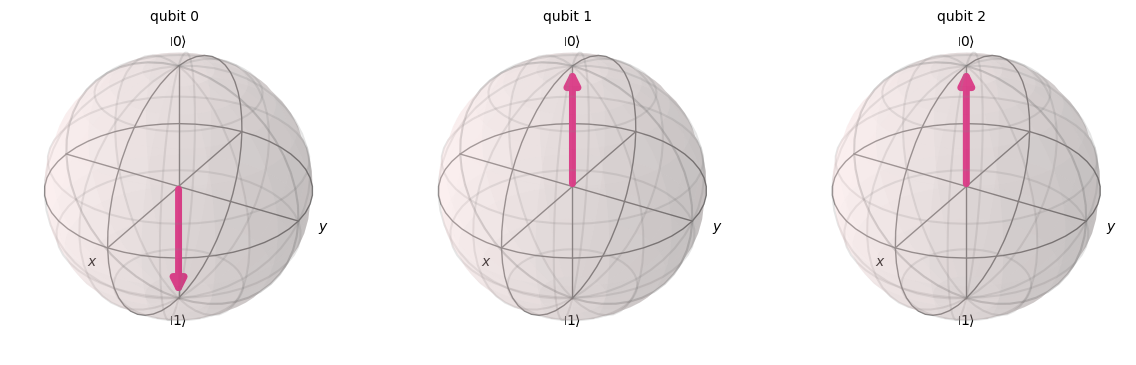

In [5]:
qc_copy = qc.copy()
qc_copy.save_statevector()
result = simulator.run(qc_copy).result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

In [6]:
qc = qc.compose(get_qft_circuit(3))

In [7]:
qc.draw()

┌───┐                                ┌───┐   
q_0: ┤ X ├─■──────────────────────■───────┤ H ├─X─
     └───┘ │                ┌───┐ │P(π/2) └───┘ │ 
q_1: ──────┼────────■───────┤ H ├─■─────────────┼─
     ┌───┐ │P(π/4)  │P(π/2) └───┘               │ 
q_2: ┤ H ├─■────────■───────────────────────────X─
     └───┘

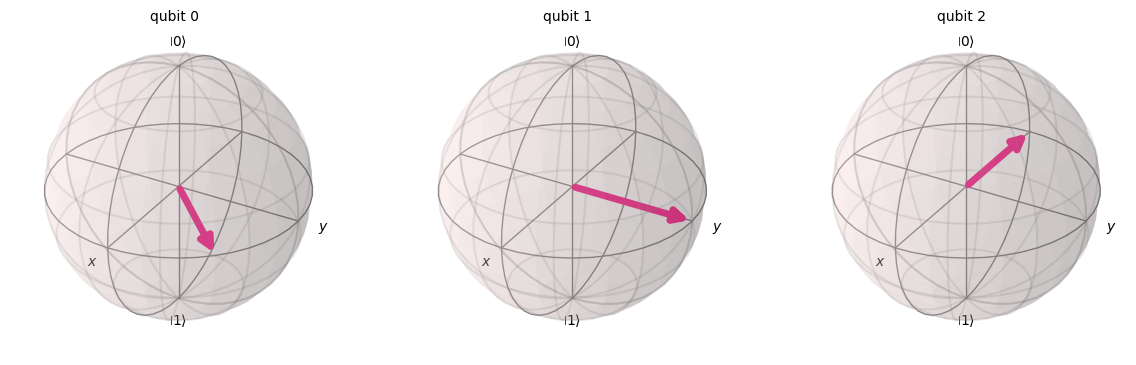

In [8]:
qc_copy = qc.copy()
qc_copy.save_statevector()
result = simulator.run(qc_copy).result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

## References